In [1]:
!git clone https://github.com/bardiarms/gan-rl.git
%cd gan-rl

Cloning into 'gan-rl'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 78 (delta 37), reused 60 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (78/78), 471.91 KiB | 8.43 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/content/gan-rl


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision torchaudio tqdm matplotlib pandas pillow

In [3]:
DATA_DIR = "/content/drive/MyDrive/gan-rl-data"
RUN_DIR  = "/content/drive/MyDrive/gan-rl-runs"

In [4]:
REPO_DIR = "/content/gan-rl"

In [5]:
import os

In [6]:
os.makedirs(RUN_DIR, exist_ok=True)
print("DATA_DIR exists:", os.path.exists(DATA_DIR))
print("RUN_DIR:", RUN_DIR)

DATA_DIR exists: True
RUN_DIR: /content/drive/MyDrive/gan-rl-runs


In [7]:
# DATA_ROOT = "/content/cartoonset100k"
DATA_ROOT = "/content/drive/MyDrive/gan-rl-data/cartoonset100k"

In [8]:
from pathlib import Path


### Storing images, corresponding metadata and their directory name

In [9]:
data_root = Path(DATA_ROOT)

pairs, missing_meta, missing_img = [], [], []

for d in sorted(data_root.iterdir()):

    for png_path in d.glob("*.png"):
        csv_path = png_path.with_suffix(".csv")
        if csv_path.exists():
            pairs.append((str(png_path), str(csv_path), int(d.name)))   # If the pair exists, add them to pairs
        else:
            missing_meta.append(str(png_path))


print("Total pairs:", len(pairs))
print("Missing CSV for PNG:", len(missing_meta))

Total pairs: 100000
Missing CSV for PNG: 17


In [ ]:
for i in range(5):
    print(pairs[i])

('/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12694632614924764393.png', '/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12694632614924764393.csv', 0)
('/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12110888894984629978.png', '/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12110888894984629978.csv', 0)
('/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12783151780612292884.png', '/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12783151780612292884.csv', 0)
('/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs1182038763634098519.png', '/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs1182038763634098519.csv', 0)
('/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs1213446833171185255.png', '/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs1213446833171185255.csv', 0)


In [10]:
pairs.sort(key=lambda x: x[0])  # sort by image path

In [11]:
from PIL import Image
import pandas as pd

In [12]:
from torchvision import transforms

In [13]:

IMG_SIZE = 64      # We convert 500*500 pixel images into 64*64.
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

In [14]:
import torch
import numpy as np

In [ ]:
# Read metadata and store them in pandas dataframe
def read_meta(meta_path: str)-> pd.DataFrame:

  df = pd.read_csv(meta_path, header=None, names=["attr", "value", "max"])
  df["attr"] = df["attr"].astype(str)
  df["value"] = df["value"].astype(int)
  df["max"] = df["max"].astype(int)

  return df

In [ ]:
# Apply one-hot encoding
def encode_onehot(meta_path: str,
                  attr_to_num_classes: dict,
                  offsets: dict,
                  total_dim: int
                  )-> torch.Tensor:

    df = read_meta(meta_path)
    vec = np.zeros((total_dim,), dtype=np.float32)

    for _, row in df.iterrows():
        attr = row["attr"]
        val = int(row["value"])

        if attr not in offsets:
          continue

        n = attr_to_num_classes[attr]
        if val < 0 or val >= n:
            val = max(0, min(val, n - 1))

        vec[offsets[attr] + val] = 1.0

    return torch.from_numpy(vec)


In [15]:
from torch.utils.data import Dataset

In [16]:
class CartoonSetDataset(Dataset):

    def __init__(self, pairs, img_transform, meta_cache = None):
        self.pairs = pairs
        self.img_transform = img_transform
        self.meta_cache = meta_cache

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, meta_path, folder_id = self.pairs[idx]

        img = Image.open(img_path).convert("RGB")
        img = self.img_transform(img)

        if self.meta_cache is not None:
            meta = self.meta_cache[meta_path]
            return img, meta, folder_id

        else:
            return img, folder_id



In [17]:
from torch.utils.data import DataLoader

In [18]:
ds = CartoonSetDataset(pairs=pairs, img_transform=img_transform)

dl = DataLoader(
    ds,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=False
)
imgs, folder_ids = next(iter(dl))
print("imgs:", imgs.shape, imgs.min().item(), imgs.max().item())
print("folder_ids:", folder_ids[:8])


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


imgs: torch.Size([4, 3, 64, 64]) -1.0 1.0
folder_ids: tensor([1, 4, 6, 3])


In [ ]:
import torch
import torch.nn as nn
from model_artifacts import models      
IMG_SIZE = 64
Z_DIM = 128
BATCH_SIZE = 4
DEVICE = "cuda"
criterion = nn.BCEWithLogitsLoss()

In [ ]:
G = models.Generator_64(z_dim=Z_DIM).to(DEVICE)
D = models.Discriminator_64().to(DEVICE)

imgs, folder_ids = next(iter(dl))  # from your existing DataLoader
imgs = imgs.to(DEVICE)

z = torch.randn(imgs.size(0), Z_DIM, device=DEVICE)
fake = G(z)

print("Real:", imgs.shape, imgs.min().item(), imgs.max().item())
print("Fake:", fake.shape, fake.min().item(), fake.max().item())

d_real = D(imgs)
d_fake = D(fake.detach())

print("D(real) shape:", d_real.shape, "min/max:", d_real.min().item(), d_real.max().item())
print("D(fake) shape:", d_fake.shape, "min/max:", d_fake.min().item(), d_fake.max().item())

Real: torch.Size([4, 3, 64, 64]) -0.9607843160629272 1.0
Fake: torch.Size([4, 3, 64, 64]) -0.9999998807907104 0.9999997019767761
D(real) shape: torch.Size([4]) min/max: -0.09946166723966599 -0.0696922019124031
D(fake) shape: torch.Size([4]) min/max: -0.13368116319179535 -0.022538205608725548


In [ ]:
# Hyperparameters
lr_G = 2e-4
lr_D = 1e-4
beta1, beta2 = 0.5, 0.999

opt_D = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(beta1, beta2))
opt_G = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(beta1, beta2))

use_amp = True
scaler_D = torch.amp.GradScaler(device="cuda", enabled=use_amp)
scaler_G = torch.amp.GradScaler(device="cuda", enabled=use_amp)

### Train GAN

In [ ]:
from torchvision.utils import make_grid, save_image

In [ ]:
# Denormalize pixels to [0,255]
def denorm(x):
    return (x * 0.5 + 0.5).clamp(0, 1)

@torch.no_grad()
def save_samples(G, step, fixed_z, out_dir, nrow=8):
    G.eval()
    fake = G(fixed_z)
    grid = make_grid(denorm(fake), nrow=nrow)
    path = os.path.join(out_dir, f"step_{step:06d}.png")
    save_image(grid, path)
    G.train()



In [ ]:
# Add Gaussian Noise to Discriminator's inputs
def noise_sigma(step, sigma0=0.10, hold_steps=1500, decay_steps=4000):
    if step < hold_steps:
        return sigma0
    t = (step - hold_steps) / decay_steps
    return sigma0 * max(0.0, 1.0 - t)

# Noise Helper
def add_instance_noise(x, sigma):
    if sigma <= 0:
        return x
    return x + sigma * torch.randn_like(x)

In [ ]:
def train_func(RUN_DIR: str,
               iters: int,
               SAMPLE_EVERY: int,
               CHKPT_EVERY: int
               )-> None:

    SAMPLES_DIR = os.path.join(RUN_DIR, f"samples_128_{iters}_iters")
    CHKPT_DIR = os.path.join(RUN_DIR, f"checkpoints_128_{iters}_iters")
    os.makedirs(SAMPLES_DIR, exist_ok=True)
    os.makedirs(CHKPT_DIR, exist_ok=True)

    fixed_z = torch.randn(64, Z_DIM, device=DEVICE)

    G.train(); D.train()

    step = 0
    data_iter = iter(dl)

    while step < iters:
        try:
            imgs, folder_ids = next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            imgs, folder_ids = next(data_iter)

        real = imgs.to(DEVICE, non_blocking=True)
        B = real.size(0)

        real_labels = torch.ones(B, device=DEVICE)
        fake_labels = torch.zeros(B, device=DEVICE)


        # ---Train Discriminator---

        opt_D.zero_grad(set_to_none=True)
        z = torch.randn(B, Z_DIM, device=DEVICE)

        sigma = 0


        with torch.amp.autocast(device_type="cuda", enabled=use_amp):
            fake = G(z)

            real_in = add_instance_noise(real, sigma)
            fake_in = add_instance_noise(fake.detach(), sigma)

            logits_real = D(real_in)
            logits_fake = D(fake_in)
            loss_D_real = criterion(logits_real, real_labels)
            loss_D_fake = criterion(logits_fake, fake_labels)
            loss_D = loss_D_real + loss_D_fake

        scaler_D.scale(loss_D).backward()
        scaler_D.step(opt_D)
        scaler_D.update()


        # ---Train Generator---

        opt_G.zero_grad(set_to_none=True)
        z = torch.randn(B, Z_DIM, device=DEVICE)

        with torch.amp.autocast(device_type="cuda", enabled=use_amp):
            fake = G(z)

            logits_fake_for_G = D(fake)
            loss_G = criterion(logits_fake_for_G, real_labels)

        scaler_G.scale(loss_G).backward()
        scaler_G.step(opt_G)
        scaler_G.update()

        # Logging
        if step % 10 == 0:
            print(
                f"step {step:04d} | "
                f"loss_D {loss_D.item():.4f} (r {loss_D_real.item():.4f}, f {loss_D_fake.item():.4f}) | "
                f"loss_G {loss_G.item():.4f} | "
                f"D(real) {logits_real.mean().item():+.3f} | D(fake) {logits_fake.mean().item():+.3f}"
            )

        # Save samples
        if step % SAMPLE_EVERY == 0:
            save_samples(G, step, fixed_z, out_dir = SAMPLES_DIR)

        # Save checkpoints
        if step > 0 and step % CHKPT_EVERY == 0:
            ckpt_path = os.path.join(CHKPT_DIR, f"gan_step_{step:06d}.pt")
            torch.save(
                {
                    "step": step,
                    "G": G.state_dict(),
                    "D": D.state_dict(),
                    "opt_G": opt_G.state_dict(),
                    "opt_D": opt_D.state_dict(),
                    "scaler_D": scaler_D.state_dict(),
                    "scaler_G": scaler_G.state_dict(),
                },
                ckpt_path,
            )

        step += 1


In [ ]:
train_func(RUN_DIR = "/content/drive/MyDrive/gan-rl-runs/12000_iters", iters = 12000, SAMPLE_EVERY = 500, CHKPT_EVERY = 500)

## Resume Train From Checkpoint

In [ ]:

def resume_from_ckpt(
    ckpt_path: str,
    total_iters: int,
    RUN_DIR: str,
    SAMPLE_EVERY: int,
    CHKPT_EVERY: int,
    dl,
    G,
    D,
    opt_G,
    opt_D,
    criterion,
    save_samples,
    DEVICE="cuda",
    Z_DIM=128,
    use_amp=True,
    scaler_D=None,
    scaler_G=None
):
    # ---- load ----
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    G.load_state_dict(ckpt["G"])
    D.load_state_dict(ckpt["D"])
    opt_G.load_state_dict(ckpt["opt_G"])
    opt_D.load_state_dict(ckpt["opt_D"])

    start_step = int(ckpt.get("step", 0)) + 1


    if "scaler_D" in ckpt and ckpt["scaler_D"] is not None:
        try:
            scaler_D.load_state_dict(ckpt["scaler_D"])
        except Exception:
            pass

    if "scaler_G" in ckpt and ckpt["scaler_G"] is not None:
        try:
            scaler_G.load_state_dict(ckpt["scaler_G"])
        except Exception:
            pass

    # ---- dirs ----
    SAMPLES_DIR = os.path.join(RUN_DIR, f"samples_64_{total_iters}_iters")
    CKPT_DIR    = os.path.join(RUN_DIR, f"checkpoints_64_{total_iters}_iters")
    os.makedirs(SAMPLES_DIR, exist_ok=True)
    os.makedirs(CKPT_DIR, exist_ok=True)

    print(f"✅ Loaded: {ckpt_path}")
    print(f"▶️ Resume: step {start_step} -> {total_iters-1}")

    fixed_z = torch.randn(64, Z_DIM, device=DEVICE)

    G.train(); D.train()
    step = start_step
    data_iter = iter(dl)

    while step < total_iters:
        try:
            imgs, folder_ids = next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            imgs, folder_ids = next(data_iter)

        real = imgs.to(DEVICE, non_blocking=True)
        B = real.size(0)

        real_labels = torch.ones(B, device=DEVICE)
        fake_labels = torch.zeros(B, device=DEVICE)


        # ---Train Discriminator---

        opt_D.zero_grad(set_to_none=True)
        z = torch.randn(B, Z_DIM, device=DEVICE)

        sigma = 0

        with torch.amp.autocast(device_type="cuda", enabled=use_amp):
            fake = G(z)

            real_in = add_instance_noise(real, sigma)
            fake_in = add_instance_noise(fake.detach(), sigma)

            logits_real = D(real_in)
            logits_fake = D(fake_in)
            loss_D_real = criterion(logits_real, real_labels)
            loss_D_fake = criterion(logits_fake, fake_labels)
            loss_D = loss_D_real + loss_D_fake

        scaler_D.scale(loss_D).backward()
        scaler_D.step(opt_D)
        scaler_D.update()



        # ---Train Generator---

        opt_G.zero_grad(set_to_none=True)
        z = torch.randn(B, Z_DIM, device=DEVICE)

        with torch.amp.autocast(device_type="cuda", enabled=use_amp):
            fake = G(z)

            logits_fake_for_G = D(fake)
            loss_G = criterion(logits_fake_for_G, real_labels)

        scaler_G.scale(loss_G).backward()
        scaler_G.step(opt_G)
        scaler_G.update()

        if step % 10 == 0:
            print(
                f"step {step:04d} | loss_D {loss_D.item():.4f} | loss_G {loss_G.item():.4f} | "
                f"D(real) {logits_real.mean().item():+.3f} | D(fake) {logits_fake.mean().item():+.3f}"
            )

        if step % SAMPLE_EVERY == 0:
            save_samples(G, step, fixed_z, out_dir=SAMPLES_DIR)

        if step > 0 and step % CHKPT_EVERY == 0:
            out_path = os.path.join(CKPT_DIR, f"gan_step_{step:06d}.pt")
            torch.save(
                {
                    "step": step,
                    "G": G.state_dict(),
                    "D": D.state_dict(),
                    "opt_G": opt_G.state_dict(),
                    "opt_D": opt_D.state_dict(),
                    "scaler_D": scaler_D.state_dict(),
                    "scaler_G": scaler_G.state_dict(),
                },
                out_path,
            )
            print("💾 Saved:", out_path)

        step += 1

In [ ]:
resume_from_ckpt(
    ckpt_path="/content/drive/MyDrive/gan-rl-runs/12000_iters/checkpoints_128_12000_iters/gan_step_002500.pt",
    total_iters=12000,
    RUN_DIR="/content/drive/MyDrive/gan-rl-runs/12000_iters/checkpoints_64_12000_iters",
    SAMPLE_EVERY=500,
    CHKPT_EVERY=500,
    dl=dl, G=G, D=D,
    opt_G=opt_G, opt_D=opt_D,
    criterion=criterion,
    save_samples=save_samples,
    DEVICE=DEVICE,
    Z_DIM=Z_DIM,
    use_amp=use_amp,
    scaler_D=scaler_D,
    scaler_G=scaler_G
)

✅ Loaded: /content/drive/MyDrive/gan-rl-runs/12000_iters/checkpoints_128_12000_iters/gan_step_002500.pt
▶️ Resume: step 2501 -> 11999
step 2510 | loss_D 1.2668 | loss_G 0.7779 | D(real) +0.051 | D(fake) -0.241
step 2520 | loss_D 0.8847 | loss_G 1.1308 | D(real) +1.030 | D(fake) -0.321
step 2530 | loss_D 0.8540 | loss_G 1.2237 | D(real) +0.876 | D(fake) -0.459
step 2540 | loss_D 1.2627 | loss_G 1.0067 | D(real) -0.065 | D(fake) -0.349
step 2550 | loss_D 1.3379 | loss_G 0.7821 | D(real) +0.273 | D(fake) +0.090
step 2560 | loss_D 1.4662 | loss_G 0.8350 | D(real) -0.111 | D(fake) +0.026
step 2570 | loss_D 1.4360 | loss_G 0.9077 | D(real) -0.210 | D(fake) -0.173
step 2580 | loss_D 1.2204 | loss_G 1.0562 | D(real) +0.464 | D(fake) +0.014
step 2590 | loss_D 1.4519 | loss_G 0.9529 | D(real) -0.163 | D(fake) -0.081
step 2600 | loss_D 1.0611 | loss_G 0.9488 | D(real) +0.577 | D(fake) -0.197
step 2610 | loss_D 1.4531 | loss_G 0.8496 | D(real) -0.121 | D(fake) -0.003
step 2620 | loss_D 1.5839 | lo

# Implement RL Agent

### Load weights from checkpoint

In [ ]:
DEVICE = "cuda"

In [ ]:
G = models.Generator_64(z_dim=128, img_channels=3, base=64).to(DEVICE)
D = models.Discriminator_64(img_channels=3, base=64).to(DEVICE)

In [ ]:
ckpt_path = "/content/drive/MyDrive/gan-rl-runs/12000_iters/checkpoints_64_12000_iters/gan_step_011500.pt"
ckpt = torch.load(ckpt_path, map_location=DEVICE)

G.load_state_dict(ckpt["G"])
D.load_state_dict(ckpt["D"])

G.eval()
D.eval()

print("Loaded checkpoint step:", ckpt.get("step", "unknown"))

Loaded checkpoint step: 11500


In [ ]:
# Freezing weights
for p in G.parameters(): p.requires_grad_(False)
for p in D.parameters(): p.requires_grad_(False)

### Latent Bank

In [ ]:
K = 512
Z_DIM = 128

Z_bank = torch.randn(K, Z_DIM, device=DEVICE)


### Reward Function Using Sigmoid

In [ ]:
@torch.no_grad()
def reward_from_latent(z_batch):

    fake = G(z_batch)
    logits = D(fake)
    r = torch.sigmoid(logits)
    return r

### Tabular Q-Learning


In [ ]:
import math

In [ ]:
Q = torch.zeros(K, device=DEVICE)

def epsilon_by_step(t, eps_start=0.2, eps_end=0.05, decay_steps=5000):
    if t >= decay_steps:
        return eps_end
    return eps_end + (eps_start - eps_end) * (1 - t / decay_steps)

def sample_action(Q, eps):
    if torch.rand(()) < eps:
        return torch.randint(0, K, (1,), device=Q.device).item()
    return torch.argmax(Q).item()

def update_Q(Q, a, r, alpha=0.1):

    Q[a] = (1 - alpha) * Q[a] + alpha * r

## Train RL Agent

In [ ]:
from collections import deque

In [ ]:
@torch.no_grad()
def run_rl_latent_selection(
    steps=10000,
    batch_size=16,
    alpha=0.1,
    print_every=50,
):
    rewards_ma = deque(maxlen=200)
    action_hist = torch.zeros(K, device=DEVICE)

    for t in range(steps):
        eps = epsilon_by_step(t)

        a = sample_action(Q, eps)
        action_hist[a] += 1

        # evaluate chosen latent
        z = Z_bank[a].unsqueeze(0).repeat(batch_size, 1)  # [B, Z_DIM]
        r = reward_from_latent(z).mean().item()

        update_Q(Q, a, r, alpha=alpha)
        rewards_ma.append(r)

        if (t % print_every) == 0:
            # policy entropy estimate from action histogram
            p = (action_hist / action_hist.sum()).clamp_min(1e-12)
            entropy = float(-(p * p.log()).sum().item())

            print(f"t={t:05d} | eps={eps:.3f} | r={r:.3f} | r_ma={sum(rewards_ma)/len(rewards_ma):.3f} | H={entropy:.2f}")

    return Q

In [ ]:
Q = run_rl_latent_selection(steps=8000, batch_size=16, alpha=0.1)

t=00000 | eps=0.200 | r=0.475 | r_ma=0.475 | H=0.00
t=00050 | eps=0.199 | r=0.475 | r_ma=0.462 | H=0.48
t=00100 | eps=0.197 | r=0.475 | r_ma=0.455 | H=0.88
t=00150 | eps=0.196 | r=0.475 | r_ma=0.451 | H=0.94
t=00200 | eps=0.194 | r=0.475 | r_ma=0.454 | H=0.83
t=00250 | eps=0.193 | r=0.475 | r_ma=0.450 | H=0.89
t=00300 | eps=0.191 | r=0.475 | r_ma=0.454 | H=0.92
t=00350 | eps=0.190 | r=0.475 | r_ma=0.456 | H=0.95
t=00400 | eps=0.188 | r=0.475 | r_ma=0.457 | H=0.98
t=00450 | eps=0.187 | r=0.475 | r_ma=0.460 | H=1.05
t=00500 | eps=0.185 | r=0.475 | r_ma=0.460 | H=1.06
t=00550 | eps=0.184 | r=0.475 | r_ma=0.458 | H=1.18
t=00600 | eps=0.182 | r=0.475 | r_ma=0.452 | H=1.20
t=00650 | eps=0.180 | r=0.475 | r_ma=0.454 | H=1.19
t=00700 | eps=0.179 | r=0.475 | r_ma=0.455 | H=1.15
t=00750 | eps=0.177 | r=0.338 | r_ma=0.453 | H=1.23
t=00800 | eps=0.176 | r=0.475 | r_ma=0.455 | H=1.24
t=00850 | eps=0.175 | r=0.475 | r_ma=0.453 | H=1.26
t=00900 | eps=0.173 | r=0.475 | r_ma=0.446 | H=1.30
t=00950 | ep

### Visualize RL-Selected VS Random Latents

In [ ]:
from torchvision.utils import make_grid, save_image

In [ ]:
@torch.no_grad()
def save_compare_grids(out_dir, n=64, nrow=8):
    os.makedirs(out_dir, exist_ok=True)

    # RL best latents
    top_idx = torch.topk(Q, k=n).indices
    z_rl = Z_bank[top_idx]  # [n, Z_DIM]
    x_rl = G(z_rl)
    grid_rl = make_grid(denorm(x_rl), nrow=nrow)
    save_image(grid_rl, os.path.join(out_dir, "rl_topk.png"))

    # Random latents
    z_rand = torch.randn(n, Z_DIM, device=DEVICE)
    x_rand = G(z_rand)
    grid_rand = make_grid(denorm(x_rand), nrow=nrow)
    save_image(grid_rand, os.path.join(out_dir, "random.png"))

    print("Saved grids to:", out_dir)

In [ ]:
save_compare_grids("/content/drive/MyDrive/gan-rl-runs/rl_eval_64")

Saved grids to: /content/drive/MyDrive/gan-rl-runs/rl_eval_64


# Evaluation

## FID

In [ ]:
!pip install pytorch-fid

In [ ]:
import os, glob, re, math
from pathlib import Path

CKPT_DIR = "/content/drive/MyDrive/gan-rl-runs/12000_iters/checkpoints_64_12000_iters"
FID_ROOT = "/content/drive/MyDrive/gan-rl-eval/fid_eval_64"
REAL_DIR = os.path.join(FID_ROOT, "real_2000")
FAKE_ROOT = os.path.join(FID_ROOT, "fake_by_step")

os.makedirs(REAL_DIR, exist_ok=True)
os.makedirs(FAKE_ROOT, exist_ok=True)

print("CKPT_DIR:", CKPT_DIR)
print("REAL_DIR:", REAL_DIR)
print("FAKE_ROOT:", FAKE_ROOT)

CKPT_DIR: /content/drive/MyDrive/gan-rl-runs/12000_iters/checkpoints_64_12000_iters
REAL_DIR: /content/drive/MyDrive/gan-rl-eval/fid_eval_64/real_2000
FAKE_ROOT: /content/drive/MyDrive/gan-rl-eval/fid_eval_64/fake_by_step


In [ ]:
import torch
from torchvision.utils import save_image
from PIL import Image

In [26]:
def load_G_from_ckpt(G, ckpt_path, device="cuda"):
    ckpt = torch.load(ckpt_path, map_location=device)
    G.load_state_dict(ckpt["G"])
    G.eval()
    for p in G.parameters():
        p.requires_grad_(False)
    step = int(ckpt.get("step", -1))
    return step

In [ ]:
N_REAL = 2000
DEVICE = "cuda"

def denorm(x):
    return (x * 0.5 + 0.5).clamp(0, 1)

@torch.no_grad()
def export_real_images(dl, out_dir, n_total=2000):

    existing = len(list(Path(out_dir).glob("*.png")))
    if existing >= n_total:
        print(f"✅ Real images already exist: {existing}")
        return

    print("Exporting real images...")
    count = 0
    for batch in dl:
        imgs = batch[0]
        imgs = imgs.to(DEVICE, non_blocking=True)
        imgs = denorm(imgs)

        for i in range(imgs.size(0)):
            path = os.path.join(out_dir, f"real_{count:05d}.png")
            save_image(imgs[i], path)
            count += 1
            if count >= n_total:
                print(f"✅ Exported {count} real images to {out_dir}")
                return

export_real_images(dl, REAL_DIR, N_REAL)

✅ Real images already exist: 2000


In [ ]:
import subprocess

def compute_fid(real_dir, fake_dir):
    cmd = ["python", "-m", "pytorch_fid", real_dir, fake_dir, "--device", "cuda"]
    out = subprocess.check_output(cmd, text=True)
    # pytorch-fid prints: "FID: XX.XXXX"
    m = re.search(r"FID:\s*([0-9.]+)", out)
    fid = float(m.group(1)) if m else None
    return fid, out


In [ ]:
from torchvision.utils import save_image

N_FAKE = 2000
Z_DIM = 128
BATCH = 64

@torch.no_grad()
def export_fake_images_for_ckpt(G, ckpt_path, out_root, n_total=2000, batch_size=64):
    step = load_G_from_ckpt(G, ckpt_path, device=DEVICE)

    out_dir = os.path.join(out_root, f"fake_step_{step:06d}")
    os.makedirs(out_dir, exist_ok=True)

    existing = len(list(Path(out_dir).glob("*.png")))
    if existing >= n_total:
        print(f"✅ Fake images already exist for step {step}: {existing}")
        return step, out_dir

    print(f"Exporting fake images for step {step} ...")
    count = 0
    while count < n_total:
        b = min(batch_size, n_total - count)
        z = torch.randn(b, Z_DIM, device=DEVICE)
        fake = G(z)
        fake = denorm(fake)

        for i in range(fake.size(0)):
            path = os.path.join(out_dir, f"fake_{count:05d}.png")
            save_image(fake[i], path)
            count += 1

    print(f"✅ Exported {n_total} fake images to {out_dir}")
    return step, out_dir

In [ ]:
from src import models

In [ ]:
G = models.Generator_64(z_dim=128, img_channels=3, base=64).to("cuda")
D = models.Discriminator_64(img_channels=3, base=64).to("cuda")

In [ ]:
import pandas as pd

EVAL_EVERY = 500  # evaluate at steps multiple of 500


ckpts = sorted(glob.glob(os.path.join(CKPT_DIR, "gan_step_*.pt")))

def step_from_name(p):
    m = re.search(r"gan_step_(\d+)\.pt", os.path.basename(p))
    return int(m.group(1)) if m else -1

ckpts = [(step_from_name(p), p) for p in ckpts]
ckpts = [(s, p) for (s, p) in ckpts if s >= 0 and (s % EVAL_EVERY == 0)]
ckpts = sorted(ckpts, key=lambda x: x[0])


print("Checkpoints selected:", [s for s,_ in ckpts])

results = []
for s, p in ckpts:
    step, fake_dir = export_fake_images_for_ckpt(G, p, FAKE_ROOT, n_total=N_FAKE, batch_size=BATCH)
    fid, _ = compute_fid(REAL_DIR, fake_dir)
    print(f"step={step} | FID={fid}")
    results.append({"step": step, "fid": fid})

df = pd.DataFrame(results).sort_values("step")
csv_path = os.path.join(FID_ROOT, "fid_results.csv")
df.to_csv(csv_path, index=False)
print("✅ Saved:", csv_path)
df

Checkpoints selected: [3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500]
Exporting fake images for step 3000 ...
✅ Exported 2000 fake images to /content/drive/MyDrive/gan-rl-eval/fid_eval_64/fake_by_step/fake_step_003000
step=3000 | FID=300.37646800373574
Exporting fake images for step 3500 ...
✅ Exported 2000 fake images to /content/drive/MyDrive/gan-rl-eval/fid_eval_64/fake_by_step/fake_step_003500
step=3500 | FID=264.46975874077464
Exporting fake images for step 4000 ...
✅ Exported 2000 fake images to /content/drive/MyDrive/gan-rl-eval/fid_eval_64/fake_by_step/fake_step_004000
step=4000 | FID=199.50375775585388
Exporting fake images for step 4500 ...
✅ Exported 2000 fake images to /content/drive/MyDrive/gan-rl-eval/fid_eval_64/fake_by_step/fake_step_004500
step=4500 | FID=246.25538491467358
Exporting fake images for step 5000 ...
✅ Exported 2000 fake images to /content/drive/MyDrive/gan-rl-eval/fid_eval_64/fake_by_step/fa

,step,fid
0,3000,300.376468
1,3500,264.469759
2,4000,199.503758
3,4500,246.255385
4,5000,320.640359
5,5500,212.307123
6,6000,315.907202
7,6500,195.450321
8,7000,252.233883
9,7500,381.614696


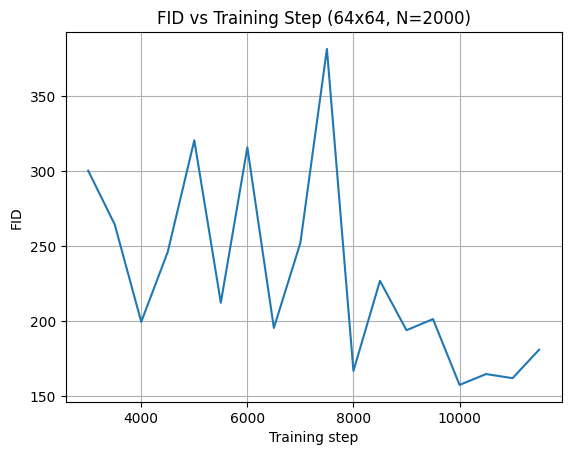

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df["step"], df["fid"])
plt.xlabel("Training step")
plt.ylabel("FID")
plt.title("FID vs Training Step (64x64, N=2000)")
plt.grid(True)
plt.show()

## LPIPS

In [ ]:
!pip install lpips


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.0 MB/s eta 0:00:00


In [ ]:
DEVICE = "cpu"

In [ ]:
CKPT_PATH = "/content/drive/MyDrive/gan-rl-runs/12000_iters/checkpoints_64_12000_iters/checkpoints_64_12000_iters/gan_step_011500.pt"


G = models.Generator_64(z_dim=128, img_channels=3, base=64).to(DEVICE)

ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
G.load_state_dict(ckpt["G"])
G.eval()
for p in G.parameters(): p.requires_grad_(False)

print("Loaded step:", ckpt.get("step", "unknown"))

Loaded step: 11500


In [ ]:
import math
from tqdm import tqdm

In [ ]:

Z_DIM = 128
M = 200          # pool size
GEN_BS = 64      # generation batch size

@torch.no_grad()
def generate_pool(G, m=200, bs=64):
    imgs = []
    n_batches = math.ceil(m / bs)
    for _ in tqdm(range(n_batches), desc="Generating fake pool"):
        b = min(bs, m - len(imgs))
        z = torch.randn(b, Z_DIM, device=DEVICE)
        x = G(z)  # [-1,1], shape [b,3,64,64]
        imgs.append(x.detach().cpu())
    return torch.cat(imgs, dim=0)[:m]

fake_pool = generate_pool(G, M, GEN_BS)
print("fake_pool:", fake_pool.shape, fake_pool.min().item(), fake_pool.max().item())

Generating fake pool: 100%|██████████| 4/4 [00:09<00:00,  2.46s/it]

fake_pool: torch.Size([200, 3, 64, 64]) -0.9999791383743286 1.0


In [ ]:
import lpips
import random
import numpy as np

In [ ]:
lpips_fn = lpips.LPIPS(net='alex').to(DEVICE)
lpips_fn.eval()

NUM_PAIRS = 100
SEED = 123

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

@torch.no_grad()
def compute_lpips_pairs(fake_pool, num_pairs=100):
    M = fake_pool.size(0)
    pairs = []
    scores = []

    for _ in tqdm(range(num_pairs), desc="Computing LPIPS"):
        i, j = random.sample(range(M), 2)
        x1 = fake_pool[i].unsqueeze(0).to(DEVICE)  # [1,3,64,64] in [-1,1]
        x2 = fake_pool[j].unsqueeze(0).to(DEVICE)

        d = lpips_fn(x1, x2)  # [1,1,1,1] or [1]
        d_val = float(d.view(-1).item())

        pairs.append((i, j))
        scores.append(d_val)

    df = pd.DataFrame({
        "i": [p[0] for p in pairs],
        "j": [p[1] for p in pairs],
        "lpips": scores
    }).sort_values("lpips").reset_index(drop=True)

    return df

df_lpips = compute_lpips_pairs(fake_pool, NUM_PAIRS)
df_lpips.head(), df_lpips.tail()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


Computing LPIPS: 100%|██████████| 100/100 [00:02<00:00, 37.48it/s]


(     i    j     lpips
 0  144   80  0.051936
 1  161  184  0.057893
 2   94   32  0.064466
 3   27    9  0.078389
 4  173   36  0.079051,
       i    j     lpips
 95  163  134  0.288987
 96  163  170  0.290612
 97   43   85  0.330486
 98   67  120  0.346448
 99   32    5  0.350479)

In [ ]:
import os
from torchvision.utils import make_grid, save_image


In [ ]:
OUT_DIR = "/content/drive/MyDrive/gan-rl-runs/12000_iters/lpips_eval_step_11500"
os.makedirs(OUT_DIR, exist_ok=True)

def denorm(x):
    return (x * 0.5 + 0.5).clamp(0, 1)

@torch.no_grad()
def save_pair(fake_pool, i, j, fname):
    x1 = denorm(fake_pool[i])
    x2 = denorm(fake_pool[j])
    grid = make_grid(torch.stack([x1, x2], dim=0), nrow=2)
    save_image(grid, os.path.join(OUT_DIR, fname))

low3 = df_lpips.iloc[:3]
high3 = df_lpips.iloc[-3:]

for k, row in enumerate(low3.itertuples(index=False), 1):
    save_pair(fake_pool, row.i, row.j, f"low_lpips_{k}_val_{row.lpips:.4f}.png")

for k, row in enumerate(high3.itertuples(index=False), 1):
    save_pair(fake_pool, row.i, row.j, f"high_lpips_{k}_val_{row.lpips:.4f}.png")

csv_path = os.path.join(OUT_DIR, "lpips_pairs.csv")
df_lpips.to_csv(csv_path, index=False)

print("Saved pairs + CSV to:", OUT_DIR)
print("CSV:", csv_path)

Saved pairs + CSV to: /content/drive/MyDrive/gan-rl-runs/12000_iters/lpips_eval_step_11500
CSV: /content/drive/MyDrive/gan-rl-runs/12000_iters/lpips_eval_step_11500/lpips_pairs.csv


In [ ]:
print("LPIPS summary over", NUM_PAIRS, "pairs")
print("mean:", df_lpips["lpips"].mean())
print("std :", df_lpips["lpips"].std())
print("min :", df_lpips["lpips"].min())
print("max :", df_lpips["lpips"].max())

print("\nLowest 3 pairs:")
print(low3)

print("\nHighest 3 pairs:")
print(high3)

LPIPS summary over 100 pairs
mean: 0.17383772969245911
std : 0.06392530398543005
min : 0.05193610489368439
max : 0.3504791259765625

Lowest 3 pairs:
     i    j     lpips
0  144   80  0.051936
1  161  184  0.057893
2   94   32  0.064466

Highest 3 pairs:
     i    j     lpips
97  43   85  0.330486
98  67  120  0.346448
99  32    5  0.350479


## Discriminator Evaluation

In [ ]:
CKPT_PATH = "/content/drive/MyDrive/gan-rl-runs/12000_iters/checkpoints_64_12000_iters/checkpoints_64_12000_iters/gan_step_011500.pt"

G = models.Generator_64(z_dim=128, img_channels=3, base=64).to(DEVICE)
D = models.Discriminator_64(img_channels=3, base=64).to(DEVICE)

ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
G.load_state_dict(ckpt["G"])
D.load_state_dict(ckpt["D"])

G.eval(); D.eval()
for p in G.parameters(): p.requires_grad_(False)
for p in D.parameters(): p.requires_grad_(False)

print("Loaded step:", ckpt.get("step", "unknown"))

Loaded step: 11500


### Confusion Matrix

In [ ]:

Z_DIM = 128
N_EVAL = 2000
BATCH = 64
THRESH = 0.5  # sigmoid threshold

@torch.no_grad()
def get_batch_imgs(batch):

    return batch[0]

@torch.no_grad()
def eval_discriminator_confusion(dl, G, D, n_eval=2000, batch_size=64, thresh=0.5):
    TP=TN=FP=FN=0
    real_probs_all = []
    fake_probs_all = []

    # --- Real pass ---
    seen = 0
    data_iter = iter(dl)
    while seen < n_eval:
        batch = next(data_iter)
        real = get_batch_imgs(batch).to(DEVICE, non_blocking=True)
        b = min(real.size(0), n_eval - seen)
        real = real[:b]
        seen += b

        logits = D(real)               # [b]
        probs  = torch.sigmoid(logits) # [b]
        real_probs_all.append(probs.detach().cpu())

        pred_real = (probs >= thresh).cpu().numpy()

        TP += int(pred_real.sum())
        FN += int((~pred_real).sum())

    # --- Fake pass ---
    seen = 0
    while seen < n_eval:
        b = min(batch_size, n_eval - seen)
        z = torch.randn(b, Z_DIM, device=DEVICE)
        fake = G(z)
        seen += b

        logits = D(fake)
        probs  = torch.sigmoid(logits)
        fake_probs_all.append(probs.detach().cpu())

        pred_real = (probs >= thresh).cpu().numpy()


        FP += int(pred_real.sum())
        TN += int((~pred_real).sum())

    real_probs_all = torch.cat(real_probs_all).numpy()
    fake_probs_all = torch.cat(fake_probs_all).numpy()

    acc = (TP + TN) / (TP + TN + FP + FN)

    cm = np.array([[TN, FP],
                   [FN, TP]])

    stats = {
        "TP": TP, "TN": TN, "FP": FP, "FN": FN,
        "acc": acc,
        "real_prob_mean": float(real_probs_all.mean()),
        "fake_prob_mean": float(fake_probs_all.mean()),
    }
    return cm, stats, real_probs_all, fake_probs_all

cm, stats, real_probs, fake_probs = eval_discriminator_confusion(dl, G, D, n_eval=N_EVAL, batch_size=BATCH, thresh=THRESH)
cm, stats

(array([[1899,  101],
        [ 770, 1230]]),
 {'TP': 1230,
  'TN': 1899,
  'FP': 101,
  'FN': 770,
  'acc': 0.78225,
  'real_prob_mean': 0.5590644478797913,
  'fake_prob_mean': 0.3534086048603058})

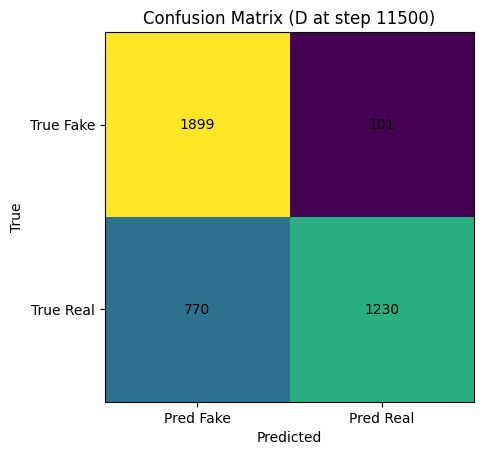

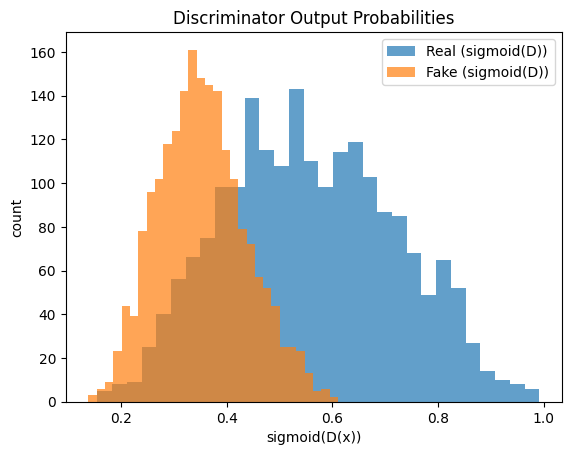

Stats: {'TP': 1230, 'TN': 1899, 'FP': 101, 'FN': 770, 'acc': 0.78225, 'real_prob_mean': 0.5590644478797913, 'fake_prob_mean': 0.3534086048603058}


In [ ]:
import matplotlib.pyplot as plt

# Confusion matrix plot
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (D at step 11500)")
plt.xticks([0,1], ["Pred Fake", "Pred Real"])
plt.yticks([0,1], ["True Fake", "True Real"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i,j]), ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Probability histograms
plt.figure()
plt.hist(real_probs, bins=30, alpha=0.7, label="Real (sigmoid(D))")
plt.hist(fake_probs, bins=30, alpha=0.7, label="Fake (sigmoid(D))")
plt.title("Discriminator Output Probabilities")
plt.xlabel("sigmoid(D(x))")
plt.ylabel("count")
plt.legend()
plt.show()

print("Stats:", stats)

In [ ]:
from torchvision.utils import save_image

In [ ]:


OUT_DIR = "/content/drive/MyDrive/gan-rl-runs/12000_iters/disc_eval_step_11500"
os.makedirs(OUT_DIR, exist_ok=True)

def denorm(x): return (x*0.5 + 0.5).clamp(0,1)

@torch.no_grad()
def collect_examples(dl, G, D, thresh=0.5, max_each=8):
    examples = {"TP": [], "TN": [], "FP": [], "FN": []}

    # collect from real
    for batch in dl:
        real = get_batch_imgs(batch).to(DEVICE, non_blocking=True)
        probs = torch.sigmoid(D(real))
        pred_real = probs >= thresh
        for i in range(real.size(0)):
            if pred_real[i] and len(examples["TP"]) < max_each:
                examples["TP"].append(real[i].cpu())
            if (not pred_real[i]) and len(examples["FN"]) < max_each:
                examples["FN"].append(real[i].cpu())
        if len(examples["TP"])>=max_each and len(examples["FN"])>=max_each:
            break

    # collect from fake
    while len(examples["TN"]) < max_each or len(examples["FP"]) < max_each:
        b = 64
        z = torch.randn(b, Z_DIM, device=DEVICE)
        fake = G(z)
        probs = torch.sigmoid(D(fake))
        pred_real = probs >= thresh
        for i in range(fake.size(0)):
            if (not pred_real[i]) and len(examples["TN"]) < max_each:
                examples["TN"].append(fake[i].cpu())
            if pred_real[i] and len(examples["FP"]) < max_each:
                examples["FP"].append(fake[i].cpu())

    return examples

ex = collect_examples(dl, G, D, THRESH, max_each=8)

for k, imgs in ex.items():
    if len(imgs) == 0:
        continue
    grid = torch.stack(imgs, dim=0)
    save_image(denorm(grid), os.path.join(OUT_DIR, f"{k}_examples.png"), nrow=4)
    print("Saved", k, "->", os.path.join(OUT_DIR, f"{k}_examples.png"))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Saved TP -> /content/drive/MyDrive/gan-rl-runs/12000_iters/disc_eval_step_11500/TP_examples.png
Saved TN -> /content/drive/MyDrive/gan-rl-runs/12000_iters/disc_eval_step_11500/TN_examples.png
Saved FP -> /content/drive/MyDrive/gan-rl-runs/12000_iters/disc_eval_step_11500/FP_examples.png
Saved FN -> /content/drive/MyDrive/gan-rl-runs/12000_iters/disc_eval_step_11500/FN_examples.png


## Training Stability Plots

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
LOG_PATH = "/content/drive/MyDrive/gan-rl-runs/12000_iters/gan_train.log"
OUT_PREFIX = "/content/drive/MyDrive/gan-rl-runs/12000_iters/gan_losses"

step_pat = re.compile(
    r"step\s+(\d+)\s+\|\s+loss_D\s+([0-9]*\.?[0-9]+)\s+\|\s+loss_G\s+([0-9]*\.?[0-9]+)"
)

rows = []
with open(LOG_PATH, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        m = step_pat.search(line)
        if m:
            step = int(m.group(1))
            loss_d = float(m.group(2))
            loss_g = float(m.group(3))
            rows.append((step, loss_d, loss_g))

df = pd.DataFrame(rows, columns=["step", "loss_D", "loss_G"]).sort_values("step").drop_duplicates("step")
print(df.head(), "\n...\n", df.tail())
print("Parsed points:", len(df))

# Loss_D plot
plt.figure()
plt.plot(df["step"], df["loss_D"])
plt.xlabel("Training step")
plt.ylabel("Discriminator loss")
plt.title("GAN training: Discriminator loss")
plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_lossD.png", dpi=200)
plt.close()

# Loss_G plot
plt.figure()
plt.plot(df["step"], df["loss_G"])
plt.xlabel("Training step")
plt.ylabel("Generator loss")
plt.title("GAN training: Generator loss")
plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_lossG.png", dpi=200)
plt.close()



   step  loss_D  loss_G
0  2510  1.2668  0.7779
1  2520  0.8847  1.1308
2  2530  0.8540  1.2237
3  2540  1.2627  1.0067
4  2550  1.3379  0.7821 
...
       step  loss_D  loss_G
944  11950  1.1114  1.1692
945  11960  1.2996  0.8227
946  11970  0.9366  1.2292
947  11980  1.1893  1.4127
948  11990  0.9937  1.3253
Parsed points: 949





## Fixed Seed



In [ ]:

OUT_REPRO = "/content/drive/MyDrive/gan-rl-runs/12000_iters/repro_eval_step_11500"
os.makedirs(OUT_REPRO, exist_ok=True)

@torch.no_grad()
def save_fixed_seed_grid(G, seed, path, n=64, nrow=8):
    torch.manual_seed(seed)
    z = torch.randn(n, Z_DIM, device=DEVICE)
    x = denorm(G(z))
    grid = make_grid(x, nrow=nrow)
    save_image(grid, path)

save_fixed_seed_grid(G, seed=2025, path=os.path.join(OUT_REPRO, "fixed_seed_run1.png"))
save_fixed_seed_grid(G, seed=2025, path=os.path.join(OUT_REPRO, "fixed_seed_run2.png"))
print("Saved reproducibility grids to:", OUT_REPRO)

Saved reproducibility grids to: /content/drive/MyDrive/gan-rl-runs/12000_iters/repro_eval_step_11500


## RL Entropy Plots

In [ ]:
LOG_PATH = "/content/drive/MyDrive/gan-rl-runs/12000_iters/rl_train.log"
OUT_PREFIX = "/content/drive/MyDrive/gan-rl-runs/12000_iters"

pat = re.compile(
    r"t=(\d+)\s*\|\s*eps=([0-9]*\.?[0-9]+)\s*\|\s*r=([0-9]*\.?[0-9]+)\s*\|\s*r_ma=([0-9]*\.?[0-9]+)\s*\|\s*H=([0-9]*\.?[0-9]+)"
)

rows = []
with open(LOG_PATH, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        m = pat.search(line)
        if m:
            t = int(m.group(1))
            eps = float(m.group(2))
            r = float(m.group(3))
            r_ma = float(m.group(4))
            H = float(m.group(5))
            rows.append((t, eps, r, r_ma, H))

df = pd.DataFrame(rows, columns=["t", "eps", "r", "r_ma", "H"]).sort_values("t").drop_duplicates("t")


plt.figure()
plt.plot(df["t"], df["H"])
plt.xlabel("t")
plt.ylabel("entropy (H)")
plt.title("Policy Entropy")
plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_entropy.png", dpi=200)
plt.close()


# Export 2000 images

In [37]:
@torch.no_grad()
def export_fake_images_for_assignment(G, ckpt_path, out_root, n_total=2000, batch_size=64):
    step = load_G_from_ckpt(G, ckpt_path, device=DEVICE)

    out_dir = out_root

    existing = len(list(Path(out_dir).glob("*.png")))
    if existing >= n_total:
        print(f"Fake images already exist for step {step}: {existing}")
        return step, out_dir

    print(f"Exporting fake images for step {step} ...")
    count = 0
    while count < n_total:
        b = min(batch_size, n_total - count)
        z = torch.randn(b, Z_DIM, device=DEVICE)
        fake = G(z)
        fake = denorm(fake)

        for i in range(fake.size(0)):
            path = os.path.join(out_dir, f"fake_{count:05d}.png")
            save_image(fake[i], path)
            count += 1

    print(f"Exported {n_total} fake images to {out_dir}")
    return step, out_dir

In [38]:
G = models.Generator_64(z_dim=128, img_channels=3, base=64).to(DEVICE)

In [39]:
def denorm(x):
    return (x * 0.5 + 0.5).clamp(0, 1)

In [40]:
from torchvision.utils import make_grid, save_image

In [41]:
### Export 2000 images from checkpoint 2000

ckpt_path = "/content/drive/MyDrive/gan-rl-runs/12000_iters/checkpoints_64_12000_iters/gan_step_011500.pt"
out_root = "/content/drive/MyDrive/gan-rl-runs/12000_iters/610300056"
step, fake_dir = export_fake_images_for_assignment(G, ckpt_path, out_root)

Exporting fake images for step 11500 ...
Exported 2000 fake images to /content/drive/MyDrive/gan-rl-runs/12000_iters/610300056


## Images can be observed using thi following link:

https://drive.google.com/drive/folders/1t-WpnVbOdo0XPRKqAiR9vpJN1hjIxBVV?usp=sharing

#Loading Weights Locally

In [ ]:
DEVICE = "cpu"

ckpt_path = "weights/gan_step_011500.pt"
ckpt = torch.load(ckpt_path, map_location=DEVICE)

G = models.Generator_64(z_dim=128, img_channels=3, base=64).to(DEVICE)
D = models.Discriminator_64(img_channels=3, base=64).to(DEVICE)

G.load_state_dict(ckpt["G"])
D.load_state_dict(ckpt["D"])

G.eval()
D.eval()

print("Loaded checkpoint step:", ckpt.get("step", "unknown"))

Loaded checkpoint step: 11500


In [ ]:
# Freezing weights
for p in G.parameters(): p.requires_grad_(False)
for p in D.parameters(): p.requires_grad_(False)